<a href="https://colab.research.google.com/github/imraunav/MNIST_GAN/blob/main/Training_cGAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import os
from time import time

In [2]:
seed = 32
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
print("Seed set!")

Seed set!


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
train_ds = MNIST("./MNIST", download=True, train=True, transform=transform)
test_ds = MNIST("./MNIST", download=True, train=False, transform=transform)

mnist_ds = ConcatDataset([train_ds, test_ds])

100%|██████████| 9912422/9912422 [00:00<00:00, 238391472.78it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93903638.62it/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79419974.70it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 11101706.74it/s]


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [5]:
batch_size = 100
dataloader = DataLoader(mnist_ds, batch_size=batch_size, shuffle=True)

In [6]:
latent_dim = 512

class Generator(nn.Module):
    def __init__(self, hidden_dim=512, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
                nn.Linear(latent_dim+num_classes, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.LeakyReLU(),

                nn.Linear(hidden_dim, 784),
        )
    def forward(self, noise, class_label):
        batch_size = noise.size(0)
        class_label = nn.functional.one_hot(class_label, self.num_classes)
        input_vectors = torch.cat([noise, class_label], dim=1)
        return self.net(input_vectors).view(batch_size, 1, 28, 28).sigmoid() # [B, C*H*W] -> [B, C, H, W]

class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
                nn.Linear(784+num_classes, 256),
                nn.Sigmoid(),
                nn.Dropout(p=0.3),

                nn.Linear(256, 256),
                nn.Sigmoid(),
                nn.Dropout(p=0.3),

                nn.Linear(256, 1),
        )
    def forward(self, img, class_label):
        batch_size = img.size(0)
        img = img.view(batch_size, -1)  # [B, C, H, W] -> [B, C*H*W]
        class_label = nn.functional.one_hot(class_label, self.num_classes)
        input_vectors = torch.cat([img, class_label], dim=1)
        return self.net(input_vectors)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)

Device:  cuda


In [8]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [9]:
# noise = torch.rand((32, latent_dim), device=device)

# img = generator(noise)
# print(img.shape)

# score = discriminator(img)
# print(score.shape)

In [10]:
# dummy_latent = torch.rand((64, latent_dim), device=device)

# dummy_img = generator(dummy_latent)

In [11]:
# dummy_img.shape

In [12]:
# from IPython.display import Image
# progress_path = "drive/MyDrive/GAN_MNIST/progress"
# os.makedirs(progress_path, exist_ok=True)
# save_image(dummy_img, progress_path+"/dummy.png", nrow=8)

# Image(os.path.join(progress_path, 'dummy.png'))

In [13]:
print(generator)
print(discriminator)

Generator(
  (net): Sequential(
    (0): Linear(in_features=522, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=794, out_features=256, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [22]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=3e-4)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=3e-4)

adv_crit = nn.BCEWithLogitsLoss().to(device)

In [23]:
def train_gen(real_batch, real_labels):

    generator.train()
    discriminator.eval()

    batch_size = real_batch.size(0)
    z = torch.normal(0, 1, (batch_size, latent_dim), device=device)
    fake_batch = generator(z, real_labels)
    # with torch.no_grad():
    #     score = discriminator(fake_batch)
    score = discriminator(fake_batch, real_labels)
    targets = torch.ones_like(score, device=device) # generator target is 1 for fake
    loss = adv_crit(score, targets)

    gen_opt.zero_grad()
    loss.backward()
    gen_opt.step()

    return loss.item()

def train_disc(real_batch, real_labels):

    generator.eval()
    discriminator.train()

    batch_size = real_batch.size(0)
    z = torch.normal(0, 1, (batch_size, latent_dim), device=device)
    with torch.no_grad():
        fake_batch = generator(z, real_labels)

    all_batch = torch.cat([real_batch, fake_batch], dim=0)
    all_labels = torch.cat([real_labels, real_labels], dim=0)
    score = discriminator(all_batch, all_labels)
    targets = torch.cat(
        [
            torch.ones((batch_size, 1), device=device),
            torch.zeros((batch_size, 1), device=device),
        ]
    )

    loss = adv_crit(score, targets)

    disc_opt.zero_grad()
    loss.backward()
    disc_opt.step()

    return loss.item()

In [24]:
def checkpoint(epoch, losses, CKPT_PATH, CKPT="checkpoint.pt"):
    progress_path = os.path.join(CKPT_PATH, "progress")

    state = {
        "epoch" : epoch,
        "generator" : generator.state_dict(),
        "discriminator" : discriminator.state_dict(),
        "gen_opt" : gen_opt.state_dict(),
        "disc_opt" : disc_opt.state_dict(),
        "losses" : losses,
    }

    os.makedirs(CKPT_PATH, exist_ok=True)
    torch.save(state, os.path.join(CKPT_PATH, CKPT))

    generator.eval()
    gen_batch = generator(sample_latent, sample_labels)

    os.makedirs(progress_path, exist_ok=True)
    save_image(gen_batch, os.path.join(progress_path, f"epoch_{epoch+1}.png"))

    print(f"! Checkpoint saved at {epoch+1}.")

In [25]:
def load_checkpoint(CKPT_PATH, CKPT="checkpoint.pt"):
    state = torch.load(os.path.join(CKPT_PATH, CKPT))
    generator.load_state_dict(state["generator"])
    discriminator.load_state_dict(state["discriminator"])

    gen_opt.load_state_dict(state["gen_opt"])
    disc_opt.load_state_dict(state["disc_opt"])

    return state["epoch"], state["losses"]

In [26]:
MAX_EPOCH = 200
CKPT_PATH = "drive/MyDrive/cGAN_MNIST"
CKPT_EVERY = 10
sample_latent = torch.normal(0, 1, (64, latent_dim), device=device)
sample_labels = torch.randint(0, 10, (64,), device=device)
print(f"Checkpoint labels to sample: {sample_labels}")

losses = {
    "gen_loss" : [],
    "disc_loss" : [],
}

start = 0
# Load checkpoint if found
if os.path.exists(CKPT_PATH+"/checkpoint.pt"):
    print("Checkpoint found")
    print('Loading checkpoint...')
    start, losses = load_checkpoint(CKPT_PATH)

tic = time()
for epoch in range(start, MAX_EPOCH):
    print(f"Epoch {epoch+1}", end=" ")
    running_losses = {
        "gen_loss" : [],
        "disc_loss" : [],
    }
    for real_batch, labels in dataloader:

        # some regularization for the discriminator for the initial stages
        real_batch = real_batch.to(device) #+ (1/(epoch+0.1))*torch.rand_like(real_batch, device=device)
        labels = labels.to(device)

        disc_loss = train_disc(real_batch, labels)
        gen_loss = train_gen(real_batch, labels)

        running_losses["disc_loss"].append(disc_loss)
        running_losses["gen_loss"].append(gen_loss)

    for loss_name in ['gen_loss', "disc_loss"]:
        epoch_loss = running_losses[loss_name]
        losses[loss_name].append(sum(epoch_loss)/len(epoch_loss))

    print(f"| G_loss : {losses['gen_loss'][-1]:.4f}, D_loss : {losses['disc_loss'][-1]:.4f}")

    if (epoch+1) % CKPT_EVERY == 0:
        checkpoint(epoch, losses, CKPT_PATH)
        # pass
toc = time()
checkpoint(epoch, losses, CKPT_PATH)
print("Training done!")
print(f"Time taken to train: {(toc-tic)/60:.3f} mins")

Checkpoint labels to sample: tensor([3, 4, 9, 7, 3, 3, 0, 6, 2, 8, 8, 3, 7, 5, 2, 0, 2, 2, 5, 9, 3, 8, 8, 7,
        1, 6, 8, 1, 7, 1, 8, 5, 1, 2, 5, 2, 2, 9, 0, 8, 9, 5, 5, 0, 4, 0, 9, 1,
        5, 2, 6, 1, 4, 1, 2, 9, 3, 8, 6, 4, 8, 8, 1, 7], device='cuda:0')
Checkpoint found
Loading checkpoint...
Epoch 101 | G_loss : 0.8508, D_loss : 0.6386
Epoch 102 | G_loss : 0.8510, D_loss : 0.6397
Epoch 103 | G_loss : 0.8576, D_loss : 0.6379
Epoch 104 | G_loss : 0.8504, D_loss : 0.6380
Epoch 105 | G_loss : 0.8529, D_loss : 0.6372
Epoch 106 | G_loss : 0.8597, D_loss : 0.6370
Epoch 107 | G_loss : 0.8553, D_loss : 0.6375
Epoch 108 | G_loss : 0.8541, D_loss : 0.6373
Epoch 109 | G_loss : 0.8551, D_loss : 0.6374
Epoch 110 | G_loss : 0.8537, D_loss : 0.6374
! Checkpoint saved at 110.
Epoch 111 | G_loss : 0.8557, D_loss : 0.6359
Epoch 112 | G_loss : 0.8573, D_loss : 0.6354
Epoch 113 | G_loss : 0.8558, D_loss : 0.6368
Epoch 114 | G_loss : 0.8602, D_loss : 0.6350
Epoch 115 | G_loss : 0.8550, D_loss : 0.6

KeyboardInterrupt: 

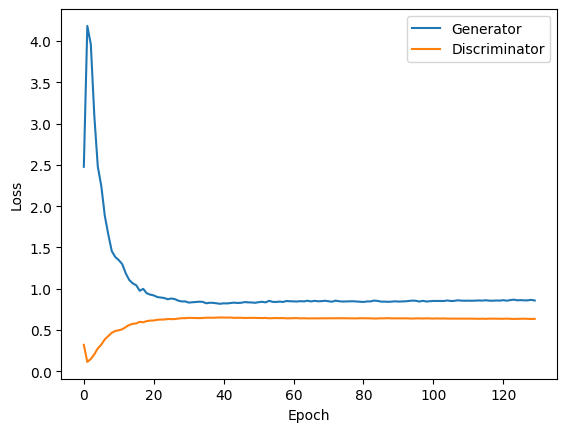

In [27]:
from matplotlib import pyplot as plt

plt.plot(losses["gen_loss"])
plt.plot(losses["disc_loss"])

plt.legend(["Generator", "Discriminator"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()